In [1]:
from pathlib import Path
import joblib
from tools.data_loader import get_data_loader
import torch
import math
from utility.survival import make_time_bins, preprocess_data
from SurvivalEVAL.Evaluations.util import predict_median_survival_time
from SurvivalEVAL.Evaluator import LifelinesEvaluator
from utility.conformal import quantile_to_survival
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                    'axes.titlesize': 'medium',
                    'font.size': 14.0,
                    'text.usetex': True,
                    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})
import seaborn as sns
import config as cfg
import numpy as np
import pandas as pd
import random

from utility.plot import load_tf_color
TFColor = load_tf_color()

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Setup precision
dtype = torch.float64
torch.set_default_dtype(dtype)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup dataset
dataset_name = "proact"

# Load data
dl = get_data_loader("proact").load_data()
train_dict, valid_dict, test_dict = dl.split_data(train_size=0.7, valid_size=0.1,
                                                  test_size=0.2, random_state=0)
n_events = dl.n_events

# Preprocess data
cat_features = dl.cat_features
num_features = dl.num_features
event_cols = [f'e{i+1}' for i in range(n_events)]
time_cols = [f't{i+1}' for i in range(n_events)]
X_train = pd.DataFrame(train_dict['X'], columns=dl.columns)
X_valid = pd.DataFrame(valid_dict['X'], columns=dl.columns)
X_test = pd.DataFrame(test_dict['X'], columns=dl.columns)
X_train, X_valid, X_test = preprocess_data(X_train, X_valid, X_test, cat_features,
                                            num_features, as_array=False)
feature_names = X_train.columns
train_dict['X'] = torch.tensor(X_train.to_numpy(), device=device, dtype=dtype)
train_dict['E'] = torch.tensor(train_dict['E'], device=device, dtype=torch.int64)
train_dict['T'] = torch.tensor(train_dict['T'], device=device, dtype=torch.int64)
valid_dict['X'] = torch.tensor(X_valid.to_numpy(), device=device, dtype=dtype)
valid_dict['E'] = torch.tensor(valid_dict['E'], device=device, dtype=torch.int64)
valid_dict['T'] = torch.tensor(valid_dict['T'], device=device, dtype=torch.int64)
test_dict['X'] = torch.tensor(X_test.to_numpy(), device=device, dtype=dtype)
test_dict['E'] = torch.tensor(test_dict['E'], device=device, dtype=torch.int64)
test_dict['T'] = torch.tensor(test_dict['T'], device=device, dtype=torch.int64)

# Make time bins
time_bins = make_time_bins(train_dict['T'].cpu(), event=None, dtype=dtype).to(device)
time_bins = torch.cat((torch.tensor([0]).to(device), time_bins))

# Load model
path = Path.joinpath(cfg.MODELS_DIR, f"conformal_{dataset_name}.pkl")
model = joblib.load(path)

c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Make predictions for all test samples
quan_levels, quan_preds = model.predict(test_dict['X'])
all_preds = []
for i in range(n_events):
    preds = quantile_to_survival(quan_levels[i], quan_preds[i], time_bins)
    preds = pd.DataFrame(preds, columns=time_bins.cpu().numpy())
    all_preds.append(preds)

In [4]:
target_row = torch.tensor([1, 1, 1, 1]) #
matches = (test_dict['E'] == target_row).all(dim=1)
torch.where(matches)[0]

tensor([ 10,  24,  38,  41,  43,  60,  64,  72,  73,  75,  77,  88,  89,  91,
        114, 127, 134, 135, 142, 143, 152, 156, 168, 174, 176, 182, 185, 190,
        192, 218, 219, 224, 231, 232, 264, 273, 274, 275, 276, 278, 281, 284,
        287, 289, 294, 301, 307, 314, 315, 324, 352, 354])

In [13]:
sample_idx = 38
event_pred_outputs = []
event_sample_tte, event_observed, event_pred_survival_times = [], [], []
for event_id in range(n_events):
    sample_tte = test_dict['T'][sample_idx, event_id]
    is_observed = (test_dict['E'][sample_idx, event_id] == 1)
    sample_pred_surv_times = all_preds[event_id].iloc[sample_idx].to_numpy()
    lifelines_eval = LifelinesEvaluator(all_preds[event_id].T,
                                        test_dict['T'][event_id],
                                        test_dict['E'][event_id],
                                        train_dict['T'][event_id],
                                        train_dict['E'][event_id])
    median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)
    pred_survival_time = median_survival_time[sample_idx]
    event_pred_outputs.append(sample_pred_surv_times)
    event_sample_tte.append(sample_tte)
    event_observed.append(is_observed)
    event_pred_survival_times.append(pred_survival_time)

In [36]:
event_sample_tte

[tensor(127), tensor(127), tensor(71), tensor(64)]

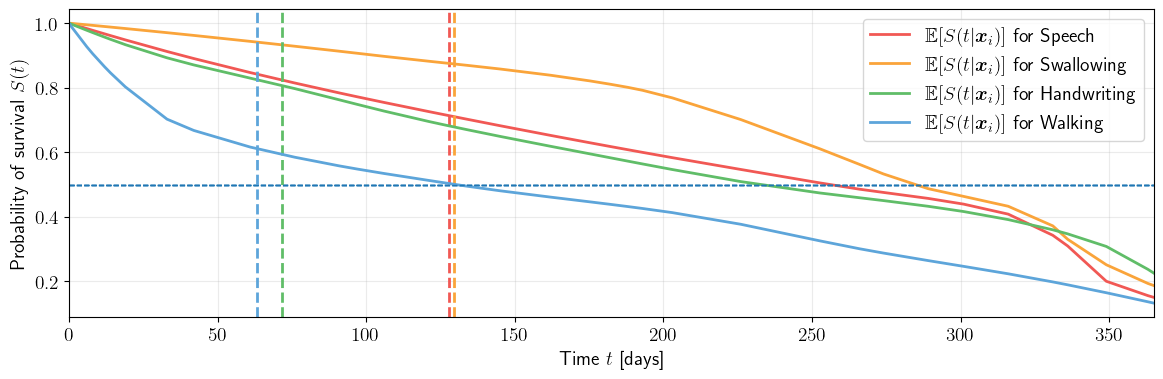

In [34]:
plt.figure(figsize=(14, 4))

event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']

# List to hold vertical line label handles and their labels
vertical_line_handles = []
vertical_line_labels = []

for i, (event_name, mean_output, sample_tte, is_observed) in \
    enumerate(zip(event_names, event_pred_outputs, event_sample_tte, event_observed)):
    
    # Plot the survival curves
    plt.plot(time_bins, mean_output, linewidth=2,
             label=r"$\mathbb{E}[S(t|\bm{x}_{i})]$" + f" for {event_name}", color=TFColor[i])
    
    # Add a horizontal dashed line at y=0.5
    plt.axhline(y=0.5, linestyle="dashed", linewidth=1)
    
    # Plot vertical lines if the event is observed
    if is_observed:
        jitter = np.random.uniform(-2.5, 2.5)
        vline = plt.axvline(x=int(sample_tte) + jitter, linestyle="dashed", linewidth=2, color=TFColor[i])
        # Store the vertical line handle and label separately
        vertical_line_handles.append(vline)
#        vertical_line_labels.append(f"Event time for {event_name}")

# Axis labels and limits
plt.ylabel("Survival Probability")
plt.xlabel("Time $t$ [days]")
plt.xlim((0, 365))

plt.tick_params(axis='y', which='both', length=0)
plt.tick_params(axis='x', which='both', length=0)

# Get the existing legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Extend the existing legend with vertical line labels
handles.extend(vertical_line_handles)
labels.extend(vertical_line_labels)

# Add the updated legend, including both survival curves and vertical lines
plt.legend(handles, labels, loc="upper right")

# Add grid
plt.grid(True, alpha=0.25)

# Save plot
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_isd.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
plt.close()
